In [1]:
import os
import os.path
os.environ['USE_PYGEOS'] = '0'
import xarray as xr
import numpy as np
import pandas as pd
import fiona
import glob
import dask_geopandas
import geopandas as gpd
import time
from copy import deepcopy
from functools import reduce

import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar

from aggfly import regions
from aggfly import dataset, regions, grid_weights
from aggfly.aggregate import TemporalAggregator, SpatialAggregator
# from aggfly.aggregate import TemporalAggregator, SpatialAggregator

ProgressBar().register()
# client = Client(n_workers=2)

project_dir = '/home3/dth2133/data/clim_data_requests/maya'

In [26]:
# Years to aggregate
years = np.arange(1951,2020)
years = years[years != 1959]

georegions = regions.from_name('counties')

In [3]:
def preprocess_era5l(array):
    # Function for cleaning the era5l data.
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):   
        # Reformat longitude
        array.coords['longitude'] = (array.coords['longitude'] + 180) % 360 - 180
        array = array.sortby(array.longitude)
        # Kelvin -> Celsius
        array = array - 273.15
    return array

# Open example dataset to construct weights.
clim = dataset.from_path(
    f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand2019.zarr", 
    var = 't2m',
    engine = 'zarr',
    name='era5',
    preprocess = preprocess_era5l)

# Calculate area and pop layer weights.
weights = grid_weights.from_objects(
    clim,
    georegions,
    wtype='pop',
    name='landscan',
    simplify=0.001,
    project_dir=project_dir)

clim.clip_data_to_georegions_extent(georegions)

print("Loading weights")
w = weights.weights()
nzw_ind = np.isin(clim.grid.index, w.cell_id).nonzero()

/home3/dth2133/data/clim_data_requests/maya/tmp/PopWeights/mod-af87cec6d77f756
/home3/dth2133/data/clim_data_requests/maya/tmp/GridWeights/mod-f176597b1a1b538
Loading weights
Loading rescaled pop weights from cache
Cache dictionary:
{'func': 'rescale_raster_to_grid',
 'grid': {'cell_area': '0.010000001788139423',
          'index': '[[     0      1      2 ...    575    576    577]\n'
                   ' [   578    579    580 ...   1153   1154   1155]\n'
                   ' [  1156   1157   1158 ...   1731   1732   1733]\n'
                   ' ...\n'
                   ' [142766 142767 142768 ... 143341 143342 143343]\n'
                   ' [143344 143345 143346 ... 143919 143920 143921]\n'
                   ' [143922 143923 143924 ... 144497 144498 144499]]',
          'lat_array': '[[49.4 49.4 49.4 ... 49.4 49.4 49.4]\n'
                       ' [49.3 49.3 49.3 ... 49.3 49.3 49.3]\n'
                       ' [49.2 49.2 49.2 ... 49.2 49.2 49.2]\n'
                       ' ...\n'
 

In [4]:
print("Scheduling aggregation")
dailies = [
    TemporalAggregator('dd', 'time.date', ddargs=[-99,20,1]),
    TemporalAggregator('dd', 'time.date', ddargs=[20,99,0]),
    TemporalAggregator('avg', 'time.date'),
    TemporalAggregator('min', 'time.date'),
    TemporalAggregator('max', 'time.date')
]
monthly = TemporalAggregator('sum', 'time.month')

Scheduling aggregation


In [ ]:
out = pd.DataFrame()
for year in years:
    print(year)
    start = time.time()

    print('Loading climate data')
    clim = dataset.from_path(
        f"/home3/dth2133/data/usa/usa-t2m_tempPrecLand{year}.zarr", 
        var = 't2m',
        engine = 'zarr',
        name='era5',
        preprocess = preprocess_era5l)
    clim.update(clim.da.persist())

    print('Aggregating')
    day_ds = [x.map_execute(clim, nzw_ind) for x in dailies]
    month_ds = [monthly.map_execute(x, nzw_ind) for x in day_ds]

    names = ['HDD_20C', 'CDD_20C', 'avg', 'min', 'max']
    df = SpatialAggregator(month_ds, w, weights.grid, names=names).compute()
    
    # Clean output dataset and append
    df = df.reset_index().rename(columns={'time':'month'})
    df['year'] = year
    df = df[['region_id', 'year', 'month'] + names]
    df = georegions.shp[['fips']].merge(df, left_index=True, right_on='region_id')

    out = pd.concat([out, df])

1951
Loading climate data
[########################################] | 100% Completed | 21.6s
Aggregating
[########################################] | 100% Completed |  8.4s
[########################################] | 100% Completed |  1min 46.3s
1952
Loading climate data
[########################################] | 100% Completed | 21.4s
Aggregating
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  1min 46.6s
1953
Loading climate data
[########################################] | 100% Completed | 20.9s
Aggregating
[########################################] | 100% Completed |  7.9s
[########################################] | 100% Completed |  1min 45.6s
1954
Loading climate data
[########################################] | 100% Completed | 21.2s
Aggregating
[########################################] | 100% Completed |  7.5s
[########################################] | 100% Completed |  1min 44.8s
1955
Loa

In [15]:
out.reset_index().to_feather("/home3/dth2133/data/clim_data_requests/maya/temp_data_maya.feather")

<AxesSubplot:>

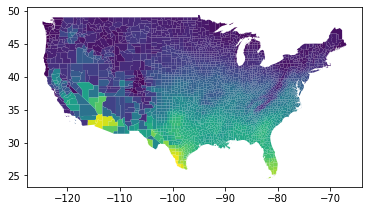

In [25]:
slc = out.loc[out.year==2019].groupby('fips').mean()
georegions.shp.merge(slc, right_index=True, left_on='fips').plot(column='CDD_20C')